# CS194-26 
## Proj 1: Colorizing the Prokudin-Gorskii photo collection

In [16]:
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.util import crop
from skimage.transform import rescale
from matplotlib import pyplot as plt
from scipy.ndimage import shift, sobel
import os

plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [2]:
def show_images(images):
    '''
    helper for displaying a collection of images
    '''
    for im in images:
        skio.imshow(im)
        skio.show()

First let's write out some helper functions

In [3]:
def split_image(imname):
    # read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    
    return b, g, r

In [4]:
def align(im1, im2, method='SSD', use_edge=False, off_x=(-15, 15), off_y=(-15, 15)):
    '''
    Does an exhaustive search over the range specified by
    off_x and off_y to find the optimal displacement vector 
    for im1 over im2
    '''
    # here I crop the images to ignore the borders
    im1_c = im1[int(0.1 * len(im1)):-int(0.1 * len(im1)),
              int(0.1 * len(im1[0])):-int(0.1 * len(im1[0]))]
    im2_c = im2[int(0.1 * len(im2)):-int(0.1 * len(im2)),
              int(0.1 * len(im2[0])):-int(0.1 * len(im2[0]))]
    
    best_score = -float('inf')
    best_shift = [0, 0]
    
    # loop over all the different displacement permutations
    for i in range(off_x[0], off_x[1] + 1):
        for j in range(off_y[0], off_y[1] + 1):
            temp_score = score(np.roll(im1_c, (i, j), (0, 1)), im2_c, method, use_edge)
            if temp_score > best_score:
                best_score = temp_score
                best_shift = [i, j]

    # return the best displaced image along with the displacement vector
    return np.roll(im1, best_shift, (0, 1)), np.array(best_shift)

def score(im1, im2, method='SSD', use_edge=False):
    '''
    returns the similarity score of im1 and im2
    '''
    if use_edge:
        im1 = np.abs(sobel(im1))
        im2 = np.abs(sobel(im2))
    if method == 'SSD':
        return -np.sum(np.sum((im1 - im2)**2)) 
    elif method == 'NCC':
        im1 = np.ndarray.flatten(im1)
        im2 = np.ndarray.flatten(im2)
        return np.dot(im1 / np.linalg.norm(im1), im2 / np.linalg.norm(im2))

Time to test it out on the cathedral image!

Green shift: [5 2]
Red shift: [12  3]


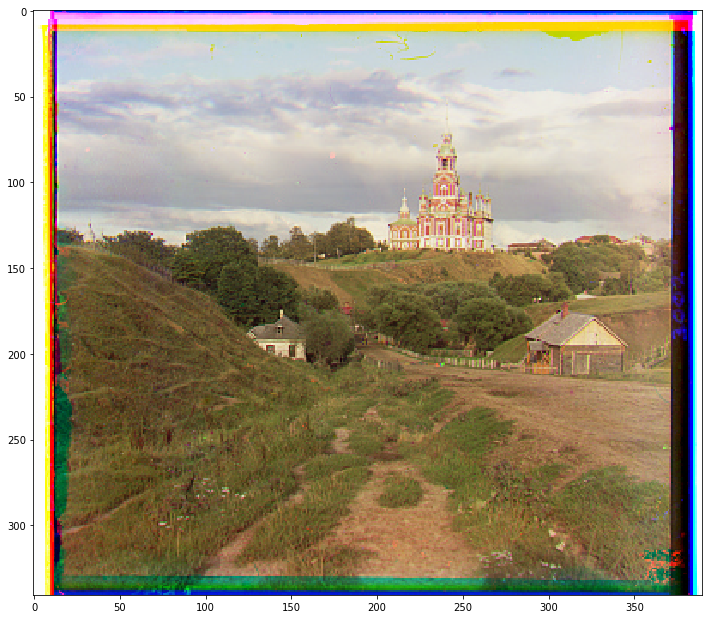

In [301]:
b, g, r = split_image("data/cathedral.jpg")

ag, g_shift = align(g, b)
ar, r_shift = align(r, b)

# create a color image
im_out = np.dstack([ar, ag, b])

print("Green shift: " + str(g_shift))
print("Red shift: " + str(r_shift))

show_images([im_out])

Great! This seems to be working well, so let's try it on the other .jpg files as well...

Method: SSD
Green shift: [-3, 2]
Red shift: [3, 2]


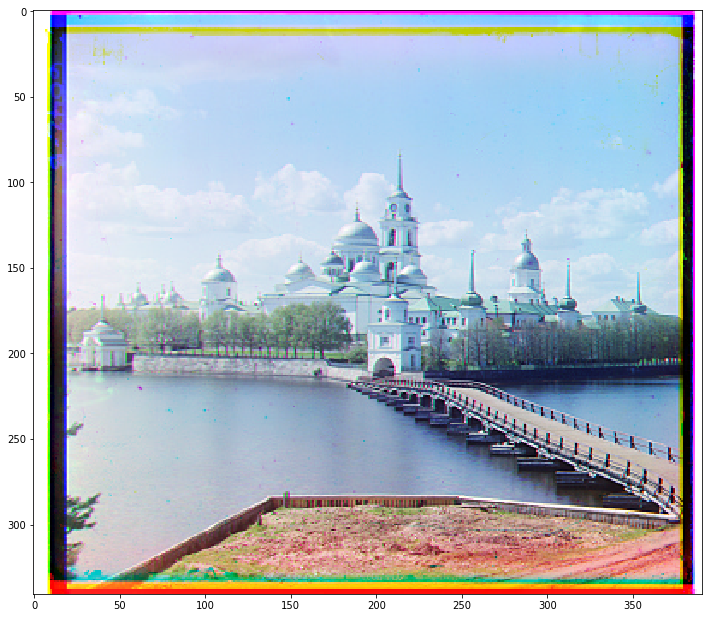

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Method: NCC
Green shift: [-3, 2]
Red shift: [3, 2]


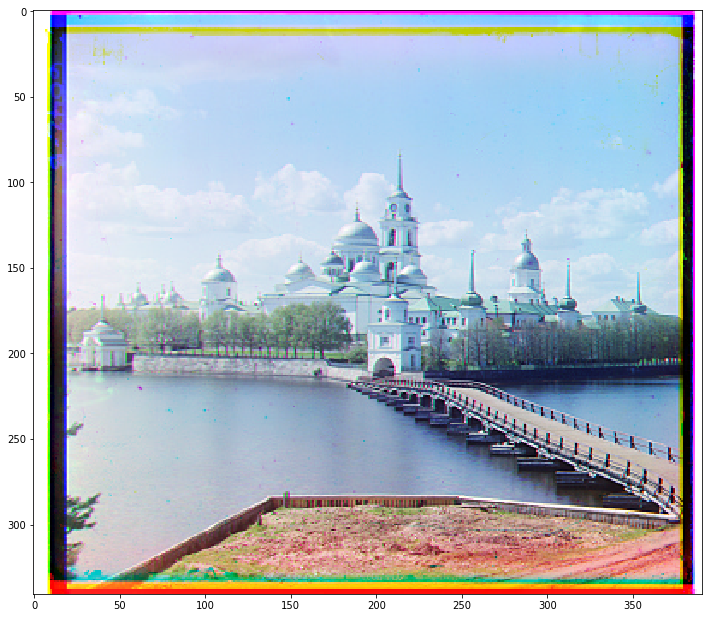

Method: SSD
Green shift: [3, 3]
Red shift: [6, 3]


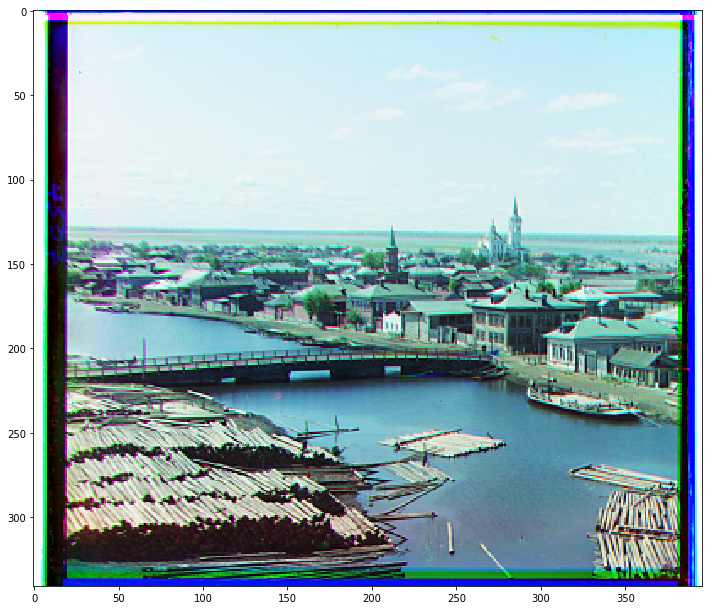

Method: NCC
Green shift: [3, 3]
Red shift: [6, 3]


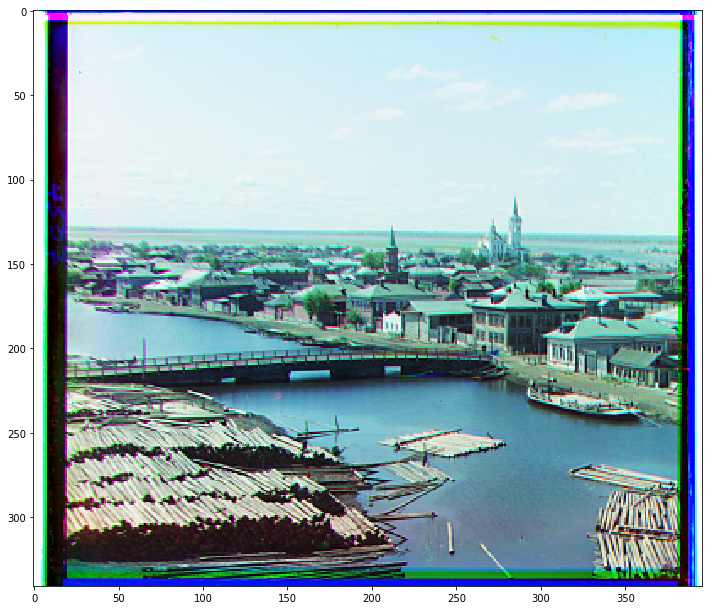

Method: SSD
Green shift: [5, 2]
Red shift: [12, 3]


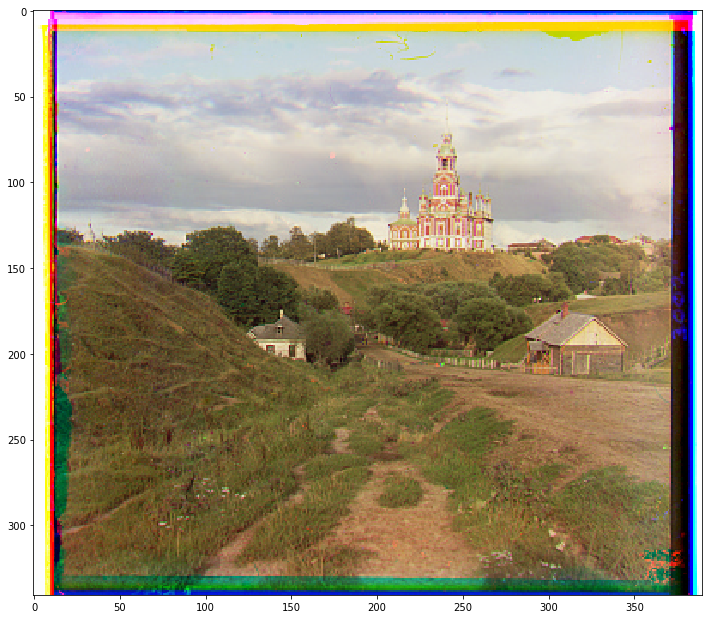

Method: NCC
Green shift: [5, 2]
Red shift: [12, 3]


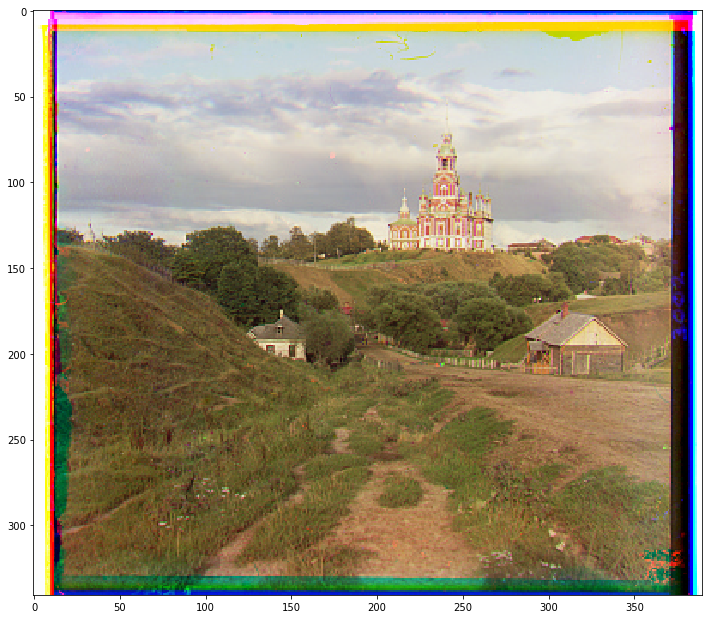

In [249]:
for filename in os.listdir("data"):
    for method in ["SSD", "NCC"]:
        if filename.endswith(".jpg"): 
            b, g, r = split_image("data/" + filename)

            ag, g_shift = align(g, b)
            ar, r_shift = align(r, b)

            # create a color image
            im_out = np.dstack([ar, ag, b])
            
            print("Method: " + method)
            print("Green shift: " + str(g_shift))
            print("Red shift: " + str(r_shift))

            show_images([im_out])        
            skio.imsave("results/result_" + method + "_g_" + str(g_shift) + \
                        "_r_" + str(r_shift) + "_" + filename, im_out)

## Now onto the .tif images...

In [14]:
def pyramid(im1, im2, method='SSD', use_edge=False, off_x=(-4, 4), off_y=(-4, 4), depth=5):
    '''
    uses the image pyramid method to deal with large-scale images
    '''
    if im1.shape[0] < 400 or depth == 0:
        return align(im1, im2, method, use_edge)
    else:
        _, best_shift = pyramid(rescale(im1, 0.5), rescale(im2, 0.5), method, depth=depth - 1)
        best_shift *= 2
        result, new_shift = align(np.roll(im1, best_shift, (0, 1)), im2, method, use_edge, off_x, off_y)
        best_shift += new_shift
        return result, best_shift

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Green shift: [52 26]
Red shift: [108  36]


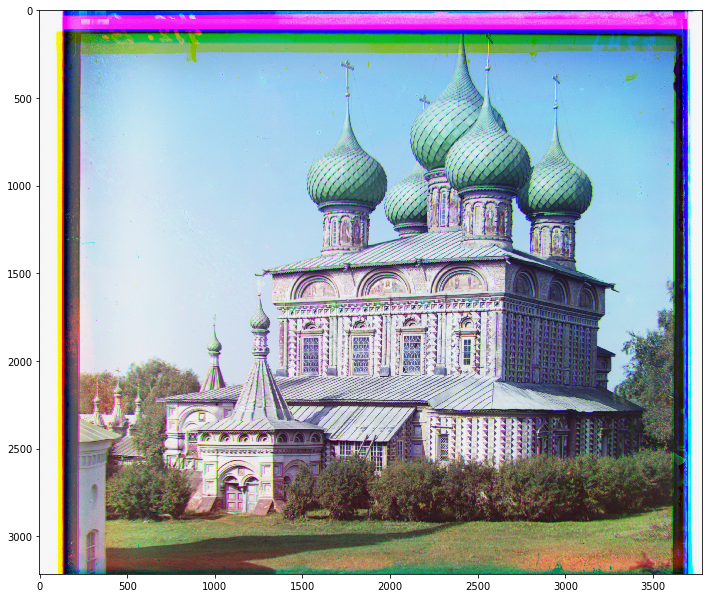

In [59]:
b, g, r = split_image("data/onion_church.tif")

# b_s = np.abs(sobel(b))
# g_s = np.abs(sobel(g))
# r_s = np.abs(sobel(r))

# _, g_shift = pyramid(g_s, b_s)
# _, r_shift = pyramid(r_s, b_s)

ag, g_shift = pyramid(g, b)
ar, r_shift = pyramid(r, b)

# ag = np.roll(g, g_shift, (0,1))
# ar = np.roll(r, r_shift, (0,1))

# create a color image
im_out = np.dstack([ar, ag, b])

print("Green shift: " + str(g_shift))
print("Red shift: " + str(r_shift))

show_images([im_out])

In [18]:
skio.imsave("proj1_web/emir_bad.jpg", im_out)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


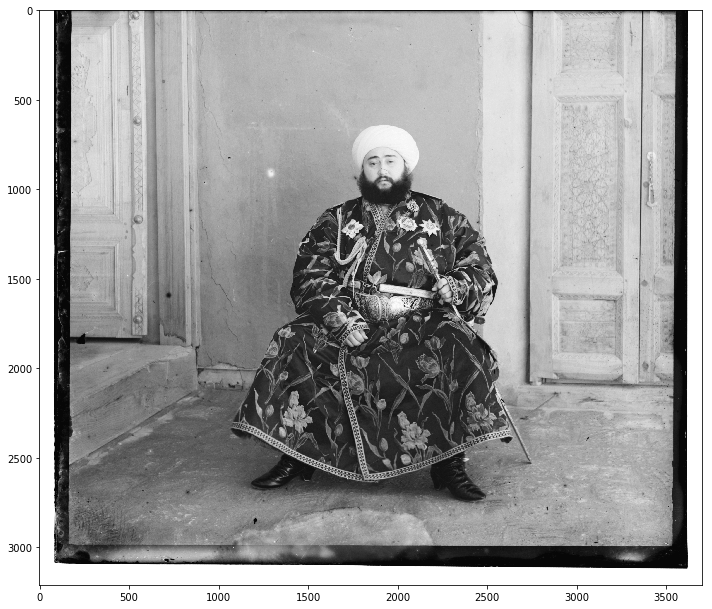

In [329]:
skio.imshow(r)

In [19]:
b, g, r = split_image("data/emir.tif")

In [11]:
skio.imsave("proj1_web/emir_b.jpg", b)
skio.imsave("proj1_web/emir_g.jpg", g)
skio.imsave("proj1_web/emir_r.jpg", r)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [12]:
for filename in os.listdir("data"):
    if filename.endswith(".tif"): 
        im = skio.imread("data/" + filename)
        skio.imsave("proj1_web/" + str.split(filename, ".")[0] + ".jpg", im)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [52]:
emir_sobel = np.abs(sobel(g))

In [53]:
emir_sobel = emir_sobel / np.max(emir_sobel)

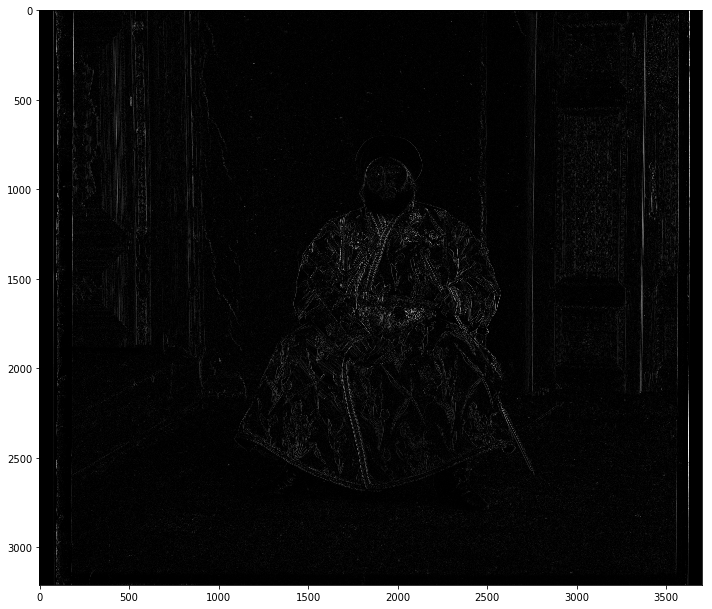

In [54]:
skio.imshow(emir_sobel)

In [55]:
skio.imsave("proj1_web/emir_sobel.jpg", emir_sobel)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [49]:
temp_b = np.zeros_like(emir_sobel)
temp_r = np.zeros_like(emir_sobel)

In [50]:
im_out = np.dstack([temp_r, temp_b, emir_sobel])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


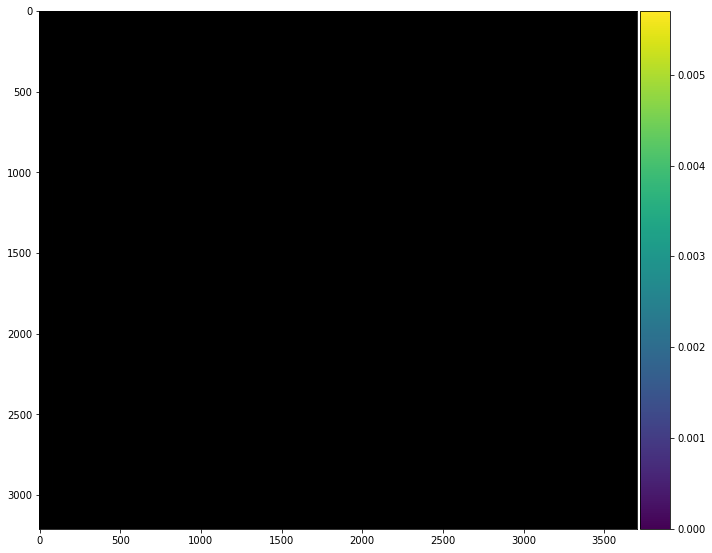

In [51]:
skio.imshow(im_out)